<a href="https://colab.research.google.com/github/mauro-cesar-bh/data-analysis/blob/main/chargeback-threshold-analysis/Mauro_Cesar_Chargeback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis of Riskified Orders

This notebook performs a data analysis on a dataset of orders to answer three key business questions:
1. What decline threshold provides a 90% approval rate?
2. What is the distribution of the model's classification scores?
3. What fee is required to achieve a 50% ratio between chargeback costs and total revenue?

### Step 1: Load the Dataset and Required Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# URL for the Google Sheet, formatted for CSV export
url = 'https://docs.google.com/spreadsheets/d/1hfTwotnfdcYctO4oRTsXCAi6WCDLeDCYksqknpLDSIQ/gviz/tq?tqx=out:csv&gid=76761202'

# Read the data into a pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows to verify it loaded correctly
print("Dataset loaded successfully. Here are the first 5 rows:")
print(df.head())

Dataset loaded successfully. Here are the first 5 rows:
    order_id  order_date order_status    price  digital_product  \
0  906967102  2019-06-01     approved   213.88            False   
1  906987974  2019-06-01     approved    50.00             True   
2  906994260  2019-06-01     approved   100.00             True   
3  906997653  2019-06-01     approved    25.00             True   
4  907408483  2019-06-01     approved  2035.76            False   

   customer_account_age order_source  billing_zip  shipping_name_length  \
0                     0          web      33062.0                    13   
1                     0   mobile_app      48317.0                     0   
2                   328          web      92124.0                     0   
3                  1371          web      95448.0                     0   
4                   139          web      61107.0                    17   

   classification_score  
0              0.999219  
1              0.995886  
2           

## Exploration

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  float64
 4   digital_product       40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40771 non-null  float64
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 2.8+ MB


In [20]:
df.describe()

,order_id,price,customer_account_age,billing_zip,shipping_name_length,classification_score
count,4.082500e+04,40825.000000,40825.000000,4.077100e+04,40825.000000,40825.000000
mean,9.288490e+08,396.114069,736.804556,4.935062e+06,4.036375,0.943287
std,1.152215e+07,771.641853,1171.305366,5.756484e+07,5.901319,0.168241
min,9.068728e+08,0.000000,-3.000000,0.000000e+00,0.000000,0.038408
25%,9.200580e+08,35.000000,0.000000,2.345100e+04,0.000000,0.988642
50%,9.291292e+08,82.440000,214.000000,4.906700e+04,0.000000,0.999177
75%,9.377158e+08,280.210000,980.000000,8.407000e+04,10.000000,0.999895
max,9.505111e+08,11033.310000,6298.000000,9.861197e+08,21.000000,1.000000


### Segmentations by score buckets
 the lower the score -> higher risk

In [35]:
# Define the bins for classification scores
bins = [i/10 for i in range(11)]

# Create a new column with the score segment
df['score_segment'] = pd.cut(df['classification_score'], bins=bins, right=False, include_lowest=True)

# Group by score segment and calculate the required metrics
segment_analysis = df.groupby('score_segment', observed=True).agg(
    num_transactions=('order_id', 'count'),
    total_amount=('price', 'sum'),
    num_chargebacks=('order_status', lambda x: (x == 'chargeback').sum()),
    total_chargeback_cost=('price', lambda x: x[df['order_status'] == 'chargeback'].sum())
).reset_index()

# Calculate shares
total_transactions = segment_analysis['num_transactions'].sum()
total_amount_all = segment_analysis['total_amount'].sum()
total_chargebacks_all = segment_analysis['num_chargebacks'].sum()

segment_analysis['share_transactions'] = (segment_analysis['num_transactions'] / total_transactions) * 100
segment_analysis['share_amount'] = (segment_analysis['total_amount'] / total_amount_all) * 100
segment_analysis['share_chargebacks'] = (segment_analysis['num_chargebacks'] / total_chargebacks_all) * 100

# Calculate share_chargebacks_amount, handling division by zero
segment_analysis['share_chargebacks_amount'] = segment_analysis.apply(
    lambda row: (row['total_chargeback_cost'] / row['total_amount']) * 100 if row['total_amount'] != 0 else 0,
    axis=1
)

# Calculate the percentage of transactions that are chargeback for each segment
segment_analysis['chargeback_rate'] = (segment_analysis['num_chargebacks'] / segment_analysis['num_transactions']) * 100

# Calculate cumulative number of transactions
segment_analysis['cumulative_transactions'] = segment_analysis['num_transactions'].cumsum()

# Format share columns as percentages with one decimal place
segment_analysis['share_transactions'] = segment_analysis['share_transactions'].round(1).astype(str) + '%'
segment_analysis['share_amount'] = segment_analysis['share_amount'].round(1).astype(str) + '%'
segment_analysis['share_chargebacks'] = segment_analysis['share_chargebacks'].round(1).astype(str) + '%'
segment_analysis['share_chargebacks_amount'] = segment_analysis['share_chargebacks_amount'].round(1).astype(str) + '%'


# Display the results
display(segment_analysis)

,score_segment,num_transactions,total_amount,num_chargebacks,total_chargeback_cost,share_transactions,share_amount,share_chargebacks,share_chargebacks_amount,chargeback_rate,cumulative_transactions
0,"[0.0, 0.1)",376,65588.30,34,6162.94,0.9%,0.4%,9.4%,9.4%,9.042553,376
1,"[0.1, 0.2)",457,76414.28,30,5197.87,1.1%,0.5%,8.3%,6.8%,6.564551,833
2,"[0.2, 0.3)",334,51608.24,17,2523.07,0.8%,0.3%,4.7%,4.9%,5.089820,1167
3,"[0.3, 0.4)",289,55364.75,28,4537.46,0.7%,0.3%,7.8%,8.2%,9.688581,1456
4,"[0.4, 0.5)",331,60076.71,17,2516.89,0.8%,0.4%,4.7%,4.2%,5.135952,1787
5,"[0.5, 0.6)",371,83512.58,15,3306.75,0.9%,0.5%,4.2%,4.0%,4.043127,2158
6,"[0.6, 0.7)",449,82958.95,17,2200.39,1.1%,0.5%,4.7%,2.7%,3.786192,2607
7,"[0.7, 0.8)",747,145325.25,25,5062.58,1.8%,0.9%,6.9%,3.5%,3.346720,3354
8,"[0.8, 0.9)",1414,254117.21,40,4110.91,3.5%,1.6%,11.1%,1.6%,2.828854,4768
9,"[0.9, 1.0)",36057,15296390.58,137,13018.26,88.3%,94.6%,38.1%,0.1%,0.379954,40825


### Task 1: Set a Decline Threshold for a 90% Approval Rate

To achieve a 90% approval rate, we must decline the 10% of orders with the lowest classification scores. The threshold for this is the 10th percentile of the `classification_score`. Any order with a score below this value will be declined.

In [43]:
# Calculate the 10th percentile of the classification_score
decline_threshold = df['classification_score'].quantile(0.10)

print(f"To achieve a 90% approval rate, the decline threshold should be set at: {decline_threshold:.4f}")

# Create two segments based on the decline threshold
df['approval_segment'] = df['classification_score'].apply(lambda x: 'Below Threshold' if x < decline_threshold else 'Above Threshold')

# Group by the new segments and calculate the required metrics
segment_threshold_analysis = df.groupby('approval_segment').agg(
    num_transactions=('order_id', 'count'),
    total_transaction_amount=('price', 'sum'),
    num_chargebacks=('order_status', lambda x: (x == 'chargeback').sum())
).reset_index()

# Calculate shares of transactions and total transaction amount
total_transactions = segment_threshold_analysis['num_transactions'].sum()
total_amount_all = segment_threshold_analysis['total_transaction_amount'].sum()

segment_threshold_analysis['share_transactions'] = (segment_threshold_analysis['num_transactions'] / total_transactions) * 100
segment_threshold_analysis['share_amount'] = (segment_threshold_analysis['total_transaction_amount'] / total_amount_all) * 100


# Calculate chargeback rate
segment_threshold_analysis['chargeback_rate'] = (segment_threshold_analysis['num_chargebacks'] / segment_threshold_analysis['num_transactions']) * 100

# Display the results
display(segment_threshold_analysis)

To achieve a 90% approval rate, the decline threshold should be set at: 0.8608


,approval_segment,num_transactions,total_transaction_amount,num_chargebacks,share_transactions,share_amount,chargeback_rate
0,Above Threshold,36742,15411656.27,154,89.998775,95.302184,0.419139
1,Below Threshold,4083,759700.58,206,10.001225,4.697816,5.045310


### Task 2: Plot the Model Scores Distribution

A histogram is an excellent way to visualize the distribution of the model's scores. This plot shows the frequency of different score ranges, which helps in understanding how the model separates fraudulent from legitimate transactions.

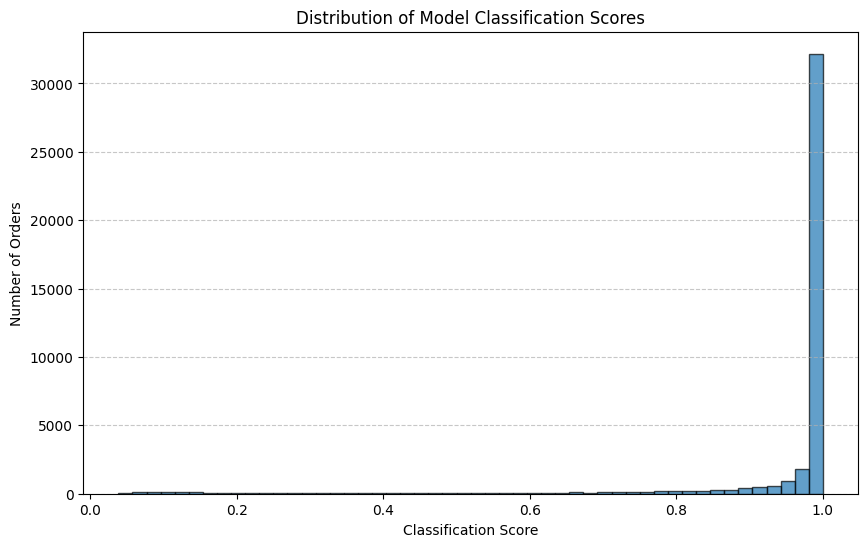

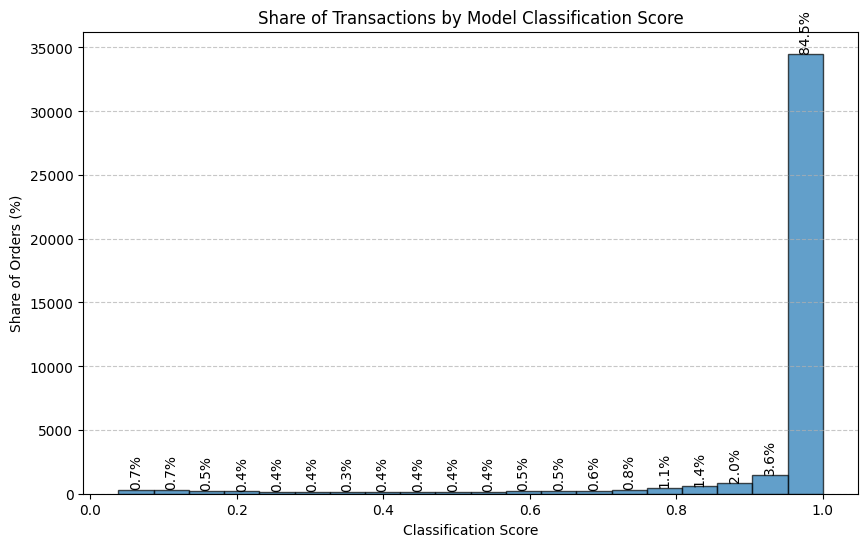

In [37]:
# Create a histogram of the classification scores
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['classification_score'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Model Classification Scores')
plt.xlabel('Classification Score')
plt.ylabel('Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a histogram with share of transactions and annotations
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['classification_score'], bins=20, edgecolor='black', alpha=0.7)

# Calculate the share of transactions in each bin
total_transactions = counts.sum()
shares = counts / total_transactions * 100

# Annotate the bars with the share percentage
for count, share, patch in zip(counts, shares, patches):
    height = patch.get_height()
    if count > 0:  # Only annotate if the count is greater than 0
        plt.text(patch.get_x() + patch.get_width() / 2., height + 50,
                 f'{share:.1f}%', ha='center', va='bottom', rotation=90)


plt.title('Share of Transactions by Model Classification Score')
plt.xlabel('Classification Score')
plt.ylabel('Share of Orders (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Task 3: Calculate the Fee for a 50% Chargeback-to-Revenue Ratio

Here, we calculate the fee (as a percentage of the order price) required to make the total cost of chargebacks (CHB) equal to 50% of the total revenue collected from fees on approved orders.

The formula is:
**Fee (%) = (Total CHB Cost) / (0.50 * Total Amount of Approved Orders)**

In [41]:
# Filter the DataFrame to include only orders with a score above the decline threshold
approved_orders_above_threshold = df[df['classification_score'] >= decline_threshold]

# Separate the orders into chargebacks and approved from this filtered DataFrame
chargebacks_above_threshold = approved_orders_above_threshold[approved_orders_above_threshold['order_status'] == 'chargeback']
approved_orders_only_above_threshold = approved_orders_above_threshold[approved_orders_above_threshold['order_status'] == 'approved']


# Calculate the total cost of chargebacks from this filtered set
total_chb_cost_above_threshold = chargebacks_above_threshold['price'].sum()

# Calculate the total amount of approved orders from this filtered set
total_approved_amount_above_threshold = approved_orders_only_above_threshold['price'].sum()


# Calculate the required fee based on the formula
# target: total_chb_cost = 0.50 * revenue
# revenue = total_approved_amount * fee
# so: total_chb_cost = 0.50 * (total_approved_amount * fee)
fee_above_threshold = total_chb_cost_above_threshold / (0.50 * total_approved_amount_above_threshold)

print(f"Total Cost of Chargebacks (Score >= Threshold): ${total_chb_cost_above_threshold:,.0f}")
print(f"Total Amount of Approved Orders (Score >= Threshold): ${total_approved_amount_above_threshold:,.0f}")
print(f"To have chargeback costs be 50% of revenue, the required fee for orders with score >= threshold is: {fee_above_threshold:.4%}")

Total Cost of Chargebacks (Score >= Threshold): $15,093
Total Amount of Approved Orders (Score >= Threshold): $15,396,563
To have chargeback costs be 50% of revenue, the required fee for orders with score >= threshold is: 0.1961%


### Next Steps
- Implement the change
- Monitor the chargeback rate for the approved transactions, make sure it does not increase (due to shutdown of other rules or to fraudsters understanding the rules)

# Appendix


In [ ]:
### Alternative Scenario where we consider that all transactions needs to be approved

In [39]:
# Separate the orders into chargebacks and approved
chargebacks = df[df['order_status'] == 'chargeback']
approved_orders = df[df['order_status'] == 'approved']

# Calculate the total cost of chargebacks
total_chb_cost = chargebacks['price'].sum()

# Calculate the total amount of all approved orders
total_approved_amount = approved_orders['price'].sum()

# Calculate the required fee based on the formula
# target: total_chb_cost = 0.50 * revenue
# revenue = total_approved_amount * fee
# so: total_chb_cost = 0.50 * (total_approved_amount * fee)
fee = total_chb_cost / (0.50 * total_approved_amount)

print(f"Total Cost of Chargebacks: ${total_chb_cost:,.0f}")
print(f"Total Amount of Approved Orders: ${total_approved_amount:,.0f}")
print(f"To have chargeback costs be 50% of revenue, the required fee is: {fee:.4%}")

Total Cost of Chargebacks: $48,637
Total Amount of Approved Orders: $16,122,720
To have chargeback costs be 50% of revenue, the required fee is: 0.6033%
